# Data requirements

Given that Github has a limited capacity to upload data, please request the dataset to David Naranjo (d.f.naranjohernandez@tudelft.nl).

In [1]:
import sys
import os
import pandas as pd

#1 Importing the main code.
module_path = os.path.abspath(os.path.join('../src/ocloc'))
if module_path not in sys.path:
    sys.path.append(module_path)
from ocloc import ProcessingParameters, ClockDrift
import ocloc

## Format of the cross-correlation file names

For working with ocloc you just need to defined the path to the directory where all cross-correlations are located.

In [2]:
path2data_dir = "/Users/localadmin/Dropbox/GitHub/data"

The cross-correlations need to be named as `station1_station2_averagedate_numberOfDaysCorrelated.sac`. 

The `averageDate` needs to have no `_` in between and should be readable using obspy's `UTCDateTime` function. An example of how the date should be formated could be:

In [3]:
import obspy
obspy.UTCDateTime("20141017T121528")

2014-10-17T12:15:28.000000Z

or in epoch format:

In [4]:
obspy.UTCDateTime(1413548128)

2014-10-17T12:15:28.000000Z

### File name example
An example of one of the file names could be:

In [5]:
os.listdir(path2data_dir)[0]

'HOS_O06_1413548128_100.sac'

Later I will show the standard way to load the cross-correlations, but to get an idea of how the traces are managed let's load only on of the files. To load only on of the cross-correaltions we can do:

In [6]:
full_path2file = os.path.join(path2data_dir, os.listdir(path2data_dir)[0])
st = ocloc.read_correlation_file(full_path2file)
print(st.stats)

         network: 
         station: 
        location: 
         channel: 
       starttime: 1969-12-31T23:30:00.000000Z
         endtime: 1970-01-01T00:29:59.960000Z
   sampling_rate: 25.0
           delta: 0.04
            npts: 90000
           calib: 1.0
         _format: SAC
    average_date: 2014-10-17T12:15:28.000000Z
  number_of_days: 100.0
             sac: AttribDict({'delta': 0.039999999, 'depmin': -442.67389, 'depmax': 445.89172, 'b': -3600.0, 'e': -0.040080465, 'depmen': 0.00011953091, 'nzyear': 1970, 'nzjday': 1, 'nzhour': 0, 'nzmin': 30, 'nzsec': 0, 'nzmsec': 0, 'nvhdr': 6, 'npts': 90000, 'iftype': 1, 'leven': 1, 'lpspol': 0, 'lovrok': 1, 'lcalda': 1, 'unused23': 0, 'kevnm': ''})
    station_pair: HOS_O06


### Correlation attributes
As you can see, the trace has an average data taken from the name of the file, a station pair with the two stations involved, the number of days correlated.
It is important to highlight that we assume that the cross-correlation file is centered around the 0 axis.



## Format of station's metadata

The station metadata is a csv file where we specify the name of the project, sensorcode, if it needs clock correction, the location, and the sensortype. Let's use Pandas to show the first 5 rows of the sample station_file:

In [7]:
station_file = "station_info"
df = pd.read_csv(station_file, delim_whitespace=True)
display(df.head(5))

,PROJECT,SENSORCODE,needs_correction(True/False),LATITUDE,LONGITUDE,ELEVATION(m),SENSORTYPE
0,IMAGE,O01,True,63.78344,-22.01142,-106.0,PZ_OBS
1,IMAGE,O02,True,63.78321,-22.22867,-100.0,PZ_OBS
2,IMAGE,O03,True,63.77156,-22.47474,-111.0,PZ_OBS
3,IMAGE,O04,True,63.75381,-22.70060,-137.0,PZ_OBS
4,IMAGE,O06,True,63.90564,-22.85941,-91.0,PZ_OBS


When adapting the station_file to your own needs modify the column (needs_correction) as this will determine which stations need clock error correction (Ussually the OBSs). In this example we set this value as True for all the OBSs, but you can also set it to True for land stations.

## Processing parameters

One of the main objects of OCloC is the `Processing_parameters` Object. Within this object we will store all the information regarding how we will process our data. Some of the parameters are:


***freqmin, freqmax***: It is important to choose an adequate bandpass filter that enhances the interferometric responses’ signal-to-noise ratio. As we are restricted to the surface-wave part of the Green’s function, choosing a frequency in the 0.1- 0.5 Hz range is recommended. Note that a low-frequency range separates the interferometric responses, while a higher frequency range makes them closer to the zero axis. This bandpass filter is defined by the freqmin, and freqmax attributes of the `ProcessingParameters object`

***snr_trh***
One critical parameter that affects the quality of the measurements is the minimum signal-to-noise ratio (SNR). If the SNR is too low, then the program will not be able to determine the arrival times of the interferometric responses. This negative effect is due to background noise that blurs the peak of the surface waves. When the peaks are not clear, the measurements might be subjected to cycle skipping, which ends up affecting the accuracy of the overall inversion.

***dist_trh***
Another important parameter to obtain accurate measurements is the minimum station separation threshold. If two stations are too close to each other, then the direct surface-wave response at positive times will overlap with the direct surface-wave response at negative times. This is detrimental for the algorithm as it is not possible to measure the arrival times of the causal and acausal waves. To prevent including these measurements, the user must select a threshold of minimum interstation separation. This threshold is expressed in terms of wavelengths since the separation also depends on the frequency range being analyzed. The values of these thresholds can be modified in the initialization step.

To initialize the `ProcessingParameters` object just do as follows:

In [8]:
params = ProcessingParameters(
                 freqmin = 0.2, # Low freq. for the bandpass filter
                 freqmax = 0.4, # High freq. for the bandpass filter 
                 ref_vel = 4500, # m/s
                 dist_trh = 2.5, # Minimum station separation in terms of wavelength
                 snr_trh = 30, # Signal-to-noise ratio threshold
                 )

# Loading the data to a ClockDrift Object.

The ClockDrift object stores all the information of the different cross-correlations, station metadata and parameters used for processing the data. If there are no cross-correlations available for a given station, the program will let you know.

In [9]:
# The reference time is zero time to which the dates of the correlations
# will be compared. It can be the date of deployment. 
reference_time = '2014-08-21T00:00:00.000000Z'

# Initialize the parameters that will be used to process al the correlation files.
processing_parameters = ProcessingParameters(
    freqmin = 0.2, # Low freq. for the bandpass filter
    freqmax = 0.4, # High freq. for the bandpass filter
    #...
    )

cd = ClockDrift(station_file, 
                 path2data_dir, 
                 reference_time, 
                 [processing_parameters])

No correlation file found for station:O26


In [10]:
print(cd)

ClockDrift object
There are 46 stations stored within the ClockDrift object. 
There are 2695 correlations stored within the ClockDrift object.



We can get an overview of the connectivity of the stations' cross-correlations by making a plot of the station pairs as:

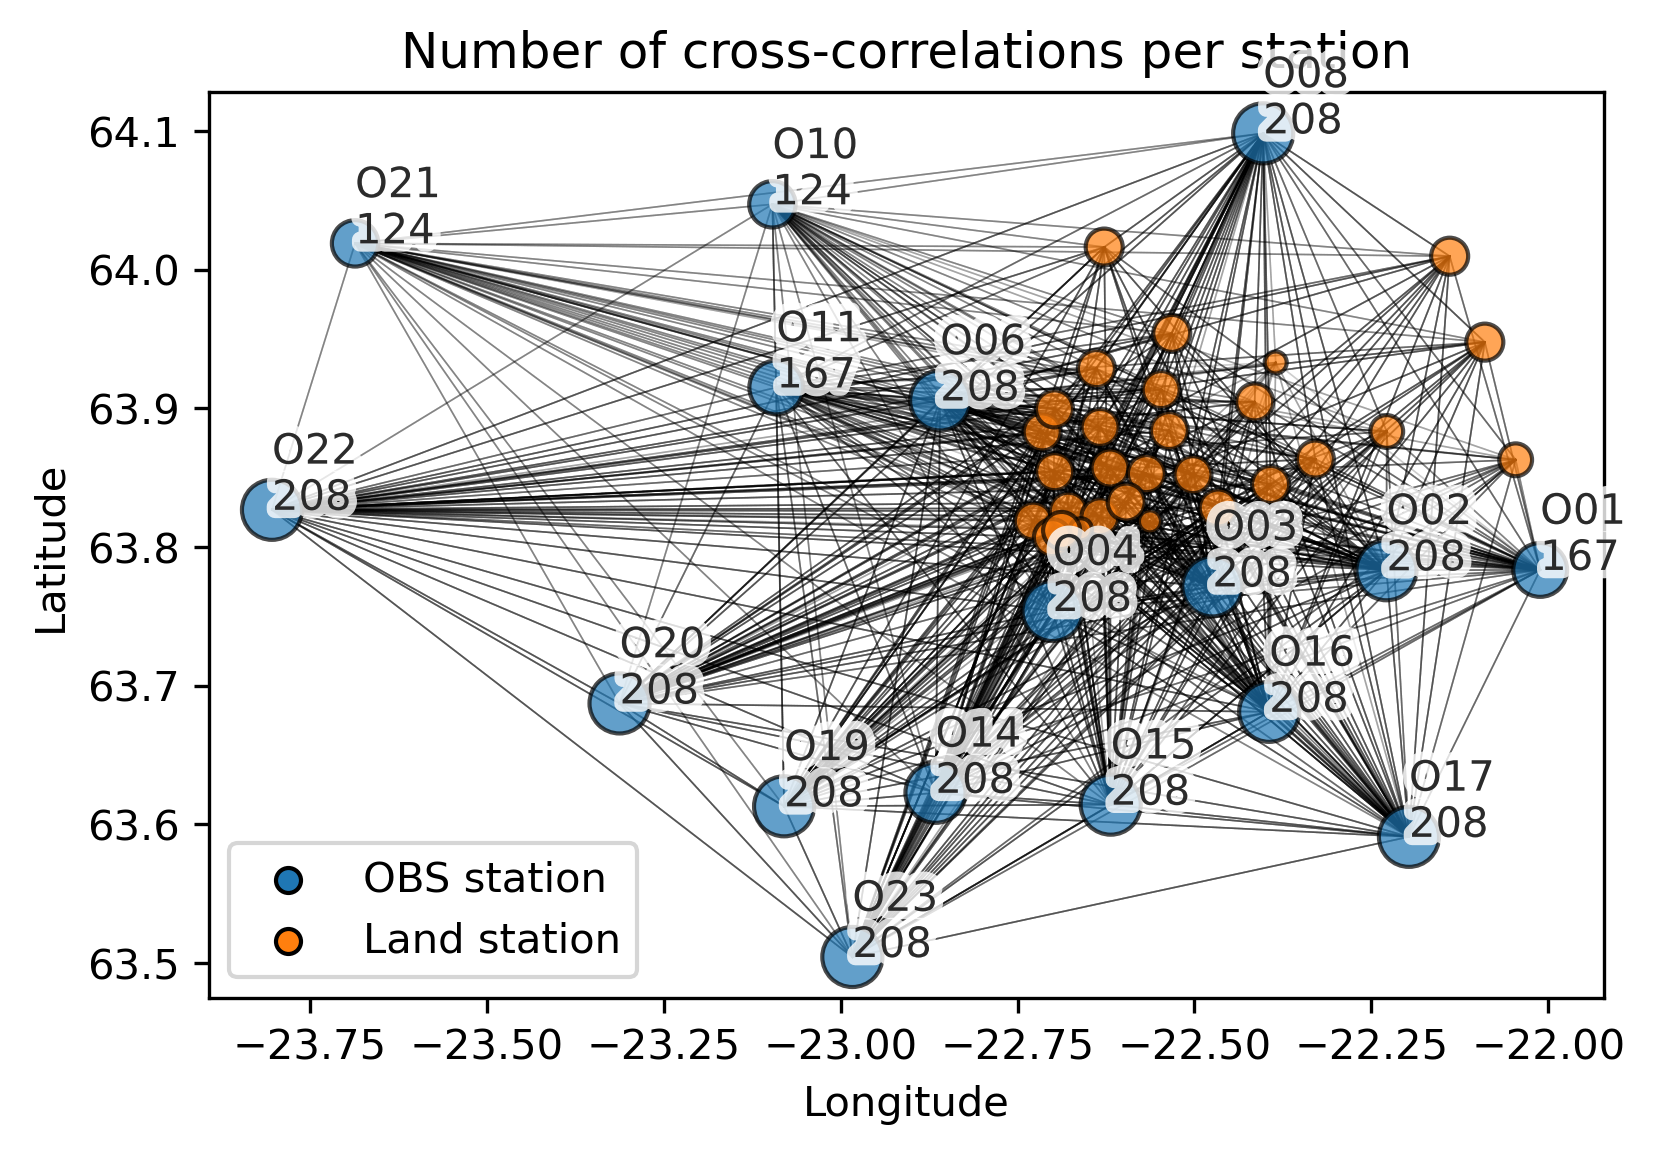

In [11]:
cd.plot_inventory_correlations()